In [1]:
import json
import requests
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import geopy.distance
from glob import glob
from datetime import datetime
from sklearn.cluster import DBSCAN
from scipy.special import lambertw
import math
import random as rd
import numpy as np
from keplergl import KeplerGl
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

### Building the record data-set

In [2]:
def convert_mac(address):
    s = str(hex(int(address)))[2:]
    while len(s)<12:
        s = "0"+s
    return ":".join(s[i:i+2] for i in range(0, len(s), 2))

def process_access_point(access_point):
    res = {'wifiAccessPoints': []}
    for i in access_point['accessPoints']:
        res['wifiAccessPoints'].append({'macAddress': convert_mac(i['mac']), 'signalStrength': i['strength'], 'signalToNoiseRatio': 0})
    return res

In [3]:
root = tk.Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
path = filedialog.askopenfilename()

f = open(path)
data = json.load(f)['locations']
f.close()
    
df = pd.DataFrame.from_dict(data)
df = df.rename(columns={"latitudeE7": "lat", "longitudeE7": "lon"})
df['lat'] = df['lat'].map(lambda x: x*10**(-7))
df['lon'] = df['lon'].map(lambda x: x*10**(-7))
df = df[df['activeWifiScan'] == df['activeWifiScan']]
df['activeWifiScan'] = df['activeWifiScan'].map(lambda x: process_access_point(x))
df['timestamp'] = pd.to_datetime(df['timestamp'])
df_records = df[['lat','lon','accuracy', 'activeWifiScan', 'timestamp']]
df_records

,lat,lon,accuracy,activeWifiScan,timestamp
0,46.521318,6.633134,14,{'wifiAccessPoints': [{'macAddress': '4c:1b:86...,2022-03-08 07:23:43.479000+00:00
1,46.521316,6.633237,14,{'wifiAccessPoints': [{'macAddress': 'b4:ee:b4...,2022-03-08 07:25:44.205000+00:00
2,46.521313,6.633247,12,{'wifiAccessPoints': [{'macAddress': 'a0:40:a0...,2022-03-08 07:27:45.966000+00:00
3,46.521320,6.633170,15,{'wifiAccessPoints': [{'macAddress': '4c:1b:86...,2022-03-08 07:29:47.276000+00:00
4,46.521313,6.633142,14,{'wifiAccessPoints': [{'macAddress': '4c:1b:86...,2022-03-08 07:31:48.279000+00:00
...,...,...,...,...,...
4993,46.521279,6.633004,20,{'wifiAccessPoints': [{'macAddress': '4c:1b:86...,2022-04-14 19:31:31.794000+00:00
4994,46.521281,6.633017,19,{'wifiAccessPoints': [{'macAddress': '4c:1b:86...,2022-04-15 04:26:19.955000+00:00
4995,46.521281,6.633017,19,{'wifiAccessPoints': [{'macAddress': '4c:1b:86...,2022-04-15 06:20:41.276000+00:00
4997,46.521281,6.633017,19,{'wifiAccessPoints': [{'macAddress': '4c:1b:86...,2022-04-15 10:15:35.513000+00:00


## WiFi Geolocation API

In [4]:
# Record that you want to use
record = df_records.iloc[0]
headers = {'Content-Type': 'application/json'}
# Key for Google Geolocation API
params = {'key': }
# Returns the response from Google API, cost 5$/1000 requests
response = requests.post('https://www.googleapis.com/geolocation/v1/geolocate', params=params, headers=headers, data=json.dumps(record['activeWifiScan']))
print(response.json())
expected = (record['lat'], record['lon'])
result = (response.json()['location']['lat'], response.json()['location']['lng'])
print('Distance between expected and result: ' + str(round(geopy.distance.geodesic(expected, result).m, 2)) + "m")


{'location': {'lat': 46.5213156, 'lng': 6.6331563}, 'accuracy': 15.545}
Distance between expected and result: 1.74m


## Reverse Geocoding API
### Creating the data set

In [5]:
def process_address(main_loc):
    return {'lat': main_loc['location']['latitudeE7']*10**(-7),
            'lon': main_loc['location']['longitudeE7']*10**(-7),
            'conf': main_loc['location']['locationConfidence'],
            'address': main_loc['location']['address'],
            'startTimestamp': main_loc['duration']['startTimestamp'],
            'endTimestamp': main_loc['duration']['endTimestamp']
            }
root = tk.Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
path = filedialog.askdirectory()

df = pd.DataFrame(columns=['lat','lon','conf','address','startTimestamp','endTimestamp'])
for f_name in glob(path+'/**/*.json'):
    f = open(f_name, encoding='utf-8')
    data = json.load(f)
    for loc in data['timelineObjects']:
        if 'placeVisit' in loc:
            loc_data = loc['placeVisit']
            df = df.append(process_address(loc_data), ignore_index=True)
    f.close()
df['startTimestamp'] = pd.to_datetime(df['startTimestamp'])
df['endTimestamp'] = pd.to_datetime(df['endTimestamp'])
df['address'] = df['address'].map(lambda x: x.replace('\n', ', '))
df = df[df['address'] != ""]
df_place = df.sample(n = 10, random_state = 1)
df_place

,lat,lon,conf,address,startTimestamp,endTimestamp
25,46.090209,6.499989,98.728004,"6 Av. de la Plaine, 74970 Marignier, France",2022-03-12 13:33:40.711000+00:00,2022-03-12 14:28:23.339000+00:00
2,46.241835,6.651135,66.073010,"71 Rte de la Villaz, 74430 Saint-Jean-d'Aulps,...",2022-04-01 17:33:48.733000+00:00,2022-04-01 19:20:37+00:00
52,46.517756,6.628457,94.437630,"Pl. de la Gare 10, 1003 Lausanne, Suisse",2022-03-28 07:00:42.916000+00:00,2022-03-28 15:34:23.104000+00:00
29,46.401642,6.594766,59.429462,"Av. Jean Léger, 74500 Évian-les-Bains, France",2022-03-13 19:34:11.518000+00:00,2022-03-13 19:44:28.551000+00:00
36,46.521257,6.632802,96.026210,"Rue du Petit-Saint-Jean 5, 1003 Lausanne, Suisse",2022-03-16 19:23:11.068000+00:00,2022-03-17 07:54:26+00:00
47,46.241835,6.651135,46.872513,"71 Rte de la Villaz, 74430 Saint-Jean-d'Aulps,...",2022-03-24 21:09:43.509000+00:00,2022-03-26 18:05:48.653000+00:00
33,46.531559,6.594695,96.045780,"Rue de Lausanne 75, 1020 Renens, Suisse",2022-03-15 19:44:37.683000+00:00,2022-03-15 22:23:14.765000+00:00
53,46.521257,6.632802,97.947300,"Rue du Petit-Saint-Jean 5, 1003 Lausanne, Suisse",2022-03-28 15:44:23.232000+00:00,2022-04-01 14:53:22.512000+00:00
35,46.521778,6.626816,97.504980,"Rue du Port-Franc 16, 1003 Lausanne, Suisse",2022-03-16 17:12:34+00:00,2022-03-16 19:19:08.118000+00:00
30,46.521257,6.632802,98.060486,"Rue du Petit-Saint-Jean 5, 1003 Lausanne, Suisse",2022-03-13 20:33:30.582000+00:00,2022-03-14 08:19:10.302000+00:00


#### Joining the records to their associated visited place using the timestamps

In [6]:
res = []
for index, row in df_place.iterrows():
    df = df_records[(row['startTimestamp'] < df_records['timestamp']) & (row['endTimestamp'] > df_records['timestamp'])]
    if (len(df) > 0):
        df['modified_lat'] = df['lat']
        df['modified_lon'] = df['lon']
        res.append([row['address'], df[['lat','lon','modified_lat','modified_lon']].copy()])

In [7]:
# Function that compute the average distance between the expected location and the one returned by Google, and the average percentage number of correct guesses
def evaluate_privacy(arr):
    result_for_each_place = []
    for place in arr:
        distance = 0
        correct_guesses = 0
        for index, record in place[1].iterrows():
            proposed_addresses = []
            #Add your Maps API key
            params = {'key': ,
                      'latlng': str(record['modified_lat']) + ',' + str(record['modified_lon']),
                      'language': 'fr'}
            response = requests.post('https://maps.googleapis.com/maps/api/geocode/json', params=params, headers=headers)
            expected_position = (record['lat'], record['lon'])
            if(len(response.json()['results'])):
                best_result = response.json()['results'][0]
                distance += geopy.distance.geodesic(expected_position, (best_result['geometry']['location']['lat'],best_result['geometry']['location']['lng'])).m
                if(place[0] == best_result['formatted_address']):
                    correct_guesses += 1
            else:
                print("Found dummy at " + str(record['modified_lat']) + ',' + str(record['modified_lon']))
                correct_guesses += 1
        result_for_each_place.append([place[0],round(distance/len(place[1]),2), round(correct_guesses/len(place[1])*100,2)])
    average_distance = 0
    average_correct_guess = 0
    for i in result_for_each_place:
        average_distance += i[1]
        average_correct_guess += i[2]
        #print('For ' + i[0] + ', the average distance to the expected point is ' + str(i[1]) + 'm and the percentage of correct guesses is ' + str(i[2]) + '%')
    print('The average distance is ' + str(round(average_distance/len(result_for_each_place),2)) + 'm and the average percentage of correct guesses is ' + str(round(average_correct_guess/len(result_for_each_place),2))+ '%')
    return [round(average_distance/len(result_for_each_place),2),round(average_correct_guess/len(result_for_each_place),2)]

### Baseline with no modifications

In [8]:
_ = evaluate_privacy(res)

The average distance is 7.57m and the average percentage of correct guesses is 33.13%


###### The mean of the records' location might give more information to Google than each individual records

In [9]:
def compute_mean_loc(arr):
    mean_loc = []
    for i in arr:
        mean_loc.append([i[0],i[1].mean(axis=0).to_frame().T])
    return mean_loc

In [10]:
_ = evaluate_privacy(compute_mean_loc(res))

The average distance is 9.0m and the average percentage of correct guesses is 40.0%


### Adding Laplacian noise

In [11]:
rd.seed(10)
def add_Laplacian_noise(df, level):
    delta = rd.random()*2*math.pi
    p = rd.random()
    r = ((-1)/level*(lambertw((p-1)/math.e, -1)+1)).real
    df['modified_lon'] = df['lon'] + r/(40075*10**3*math.cos(math.radians(df['lat']))/360)*math.cos(delta)
    df['modified_lat'] = df['lat'] + r/(111.32*10**3)*math.sin(delta)
    return df

def modify_arr_with_noise(level, arr):
    modified_res = []
    for i in arr:
        modified_res.append([i[0],i[1].copy().apply(lambda x: add_Laplacian_noise(x, level) , axis=1)])
    return modified_res

def display_map(arr):
    frames = []
    for i in arr:
        frames.append(i[1])
    df = pd.concat(frames)
    f = open('config.json')
    config = json.load(f)
    f.close()
    map_1 = KeplerGl(height=400, data={'data': df}, config=config, show_docs=False)
    return map_1

In [12]:
_ = evaluate_privacy(modify_arr_with_noise(0.1, res))

The average distance is 20.22m and the average percentage of correct guesses is 22.97%


###### Using the mean of the record

In [13]:
_ = evaluate_privacy(compute_mean_loc(modify_arr_with_noise(0.1, res)))

The average distance is 10.06m and the average percentage of correct guesses is 40.0%


In [14]:
display_map(modify_arr_with_noise(0.1, res))

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'wjpo84o', 'type': …

Same as the baseline, lets add more noise

In [15]:
_ = evaluate_privacy(compute_mean_loc(modify_arr_with_noise(0.01, res)))

The average distance is 38.76m and the average percentage of correct guesses is 10.0%


In [16]:
display_map(modify_arr_with_noise(0.01, res))

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'wjpo84o', 'type': …

In [17]:
_ = evaluate_privacy(compute_mean_loc(modify_arr_with_noise(0.001, res)))

The average distance is 498.52m and the average percentage of correct guesses is 0.0%


In [18]:
display_map(modify_arr_with_noise(0.001, res))

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'wjpo84o', 'type': …

### Adding dummies

In [19]:
def add_dummies(df, ndummies):
    for i in range(0,ndummies):
        d = df.sample(n = 1)
        d['modified_lat'] = d['modified_lat'] + (rd.random()-0.5)/1000
        d['modified_lon'] = d['modified_lon'] + (rd.random()-0.5)/1000
        df = df.append(d)
    return df

def modify_arr_with_dummies(ndummies, arr):
    modified_res = []
    for i in arr:
        modified_res.append([i[0],add_dummies(i[1],ndummies)])
    return modified_res

In [20]:
_ = evaluate_privacy(modify_arr_with_dummies(10, res))

The average distance is 15.08m and the average percentage of correct guesses is 25.07%


In [21]:
_ = evaluate_privacy(compute_mean_loc(modify_arr_with_dummies(10, res)))

The average distance is 9.93m and the average percentage of correct guesses is 40.0%


In [22]:
display_map(modify_arr_with_dummies(10, res))

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'wjpo84o', 'type': …

### Combining both

In [23]:
_ = evaluate_privacy(modify_arr_with_noise(0.01,modify_arr_with_dummies(10, res)))

The average distance is 204.53m and the average percentage of correct guesses is 0.65%


In [24]:
display_map(modify_arr_with_noise(0.01,modify_arr_with_dummies(10, res)))

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'wjpo84o', 'type': …

In [25]:
_ = evaluate_privacy(compute_mean_loc(modify_arr_with_noise(0.01,modify_arr_with_dummies(1, res))))

The average distance is 38.25m and the average percentage of correct guesses is 10.0%


## Ploting the result

The average distance is 182.39m and the average percentage of correct guesses is 1.14%
The average distance is 104.53m and the average percentage of correct guesses is 3.46%
The average distance is 68.06m and the average percentage of correct guesses is 4.76%
The average distance is 52.23m and the average percentage of correct guesses is 8.25%
The average distance is 39.71m and the average percentage of correct guesses is 11.52%
The average distance is 34.52m and the average percentage of correct guesses is 15.22%
The average distance is 30.02m and the average percentage of correct guesses is 11.26%
The average distance is 28.54m and the average percentage of correct guesses is 11.45%
The average distance is 23.38m and the average percentage of correct guesses is 17.71%


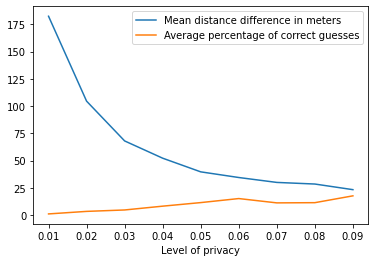

In [26]:
rd.seed(10)
privacy_levels = np.arange(0.01,0.1,0.01)
distances = []
correct_guesses = []
for i in privacy_levels:
    [dist, guess] = evaluate_privacy(modify_arr_with_noise(i, res))
    distances.append(dist)
    correct_guesses.append(guess)

plt.plot(privacy_levels, distances, label = "Mean distance difference in meters")
plt.plot(privacy_levels, correct_guesses, label = "Average percentage of correct guesses")
plt.xlabel('Level of privacy')
plt.legend()
plt.savefig('evaluating_laplacian_noise_privacy_level.png')
plt.show()

The average distance is 34.56m and the average percentage of correct guesses is 10.0%
The average distance is 38.16m and the average percentage of correct guesses is 20.0%
The average distance is 13.78m and the average percentage of correct guesses is 40.0%
The average distance is 9.79m and the average percentage of correct guesses is 30.0%
The average distance is 17.45m and the average percentage of correct guesses is 20.0%
The average distance is 11.61m and the average percentage of correct guesses is 30.0%
The average distance is 8.52m and the average percentage of correct guesses is 40.0%
The average distance is 8.44m and the average percentage of correct guesses is 40.0%
The average distance is 8.82m and the average percentage of correct guesses is 40.0%


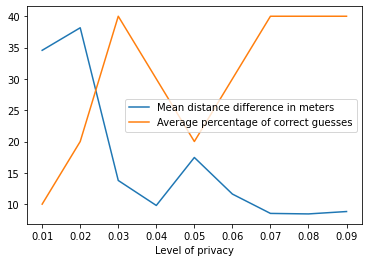

In [27]:
rd.seed(10)
privacy_levels = np.arange(0.01,0.1,0.01)
distances = []
correct_guesses = []
for i in privacy_levels:
    [dist, guess] = evaluate_privacy(compute_mean_loc(modify_arr_with_noise(i, res)))
    distances.append(dist)
    correct_guesses.append(guess)
plt.plot(privacy_levels, distances, label = "Mean distance difference in meters")
plt.plot(privacy_levels, correct_guesses, label = "Average percentage of correct guesses")
plt.legend()
plt.xlabel('Level of privacy')
plt.savefig('evaluating_laplacian_noise_privacy_level_mean.png')
plt.show()